## 🌐 Convert Depth Map to 3D Point Cloud using Open3D

---

### Import Libraries

In [4]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

### Load Depth and Color Images

- Loads the depth map (`depth_map.jpg`) using `cv2.IMREAD_UNCHANGED` to preserve raw depth values.
- Loads the RGB image (`your_image.png`) using OpenCV.
- Converts the color image from BGR (default OpenCV format) to RGB format, which is required by Open3D and most deep learning models.

In [3]:
depth_img = cv2.imread("depth_map.jpg", cv2.IMREAD_UNCHANGED)
color_img = cv2.imread("your_image.png")
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

# show the depth image
depth_normalized = cv2.normalize(depth_img, None, 0, 255, cv2.NORM_MINMAX)
depth_normalized = np.uint8(depth_normalized)

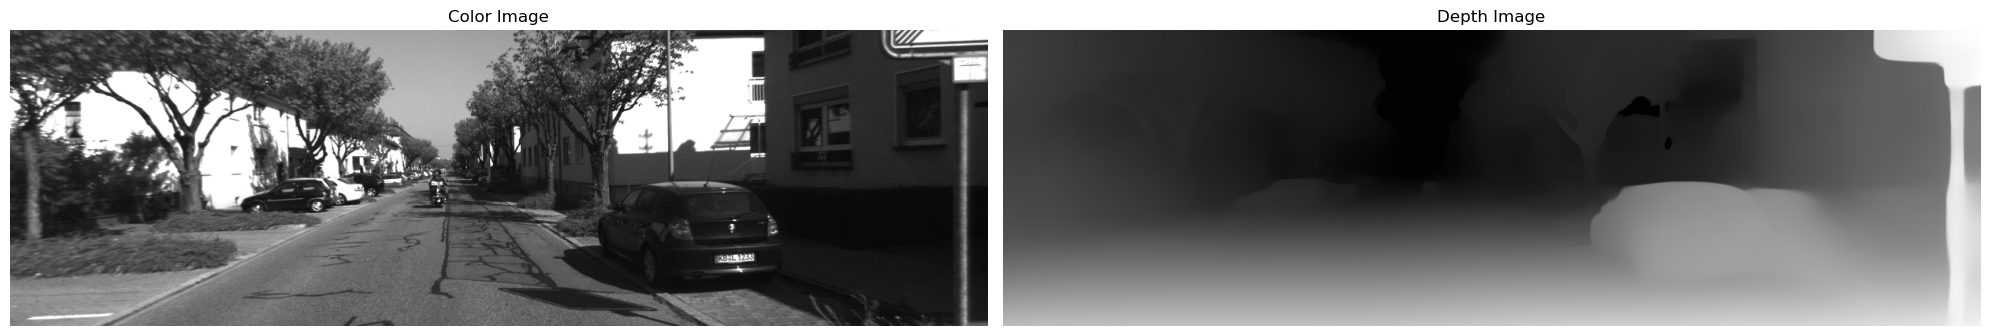

In [6]:
# Normalize depth image for display
depth_normalized = cv2.normalize(depth_img, None, 0, 255, cv2.NORM_MINMAX)
depth_normalized = np.uint8(depth_normalized)

# Plot side by side
plt.figure(figsize=(20, 16))

plt.subplot(1, 2, 1)
plt.imshow(color_img)
plt.title("Color Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(depth_normalized, cmap='gray')
plt.title("Depth Image")
plt.axis("off")

plt.tight_layout()
plt.show()

### Resize to match (if needed)

In [7]:

depth_img = cv2.resize(depth_img, (color_img.shape[1], color_img.shape[0]))

### Normalize Depth Values

- Converts the depth image to `float32` for accurate processing.
- Normalizes the depth values to a range of **0.1 to 1.0** using `cv2.normalize()`.  
  This creates a **fake depth scale** suitable for visualizing or generating a 3D point cloud.


In [9]:
depth = depth_img.astype(np.float32)
depth = cv2.normalize(depth, None, 0.1, 1.0, cv2.NORM_MINMAX)

### Define Camera Intrinsics (Approximate)

- Retrieves the height (`h`) and width (`w`) of the depth image.
- Sets **focal lengths** `fx` and `fy` to 500 (approximate value).
- Sets the **principal point** `(cx, cy)` to the center of the image.

> These intrinsics are approximate and used for demonstration. For real data, use actual camera calibration values.

In [10]:
h, w = depth.shape
fx = fy = 500
cx, cy = w / 2, h / 2

### Create Open3D RGBD Image and Intrinsics

- Converts the NumPy depth and color images to Open3D image formats.
- Combines them into an `RGBDImage` using `create_from_color_and_depth()`.
  - `convert_rgb_to_intensity=False` keeps the image in full color.
- Defines camera intrinsics using `PinholeCameraIntrinsic` with the image size and the previously defined `fx`, `fy`, `cx`, and `cy`.

This prepares the input for 3D point cloud generation.

In [11]:
depth_o3d = o3d.geometry.Image(depth)
color_o3d = o3d.geometry.Image(color_img)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_o3d, depth_o3d, convert_rgb_to_intensity=False)

intrinsics = o3d.camera.PinholeCameraIntrinsic(w, h, fx, fy, cx, cy)

### Create and Transform 3D Point Cloud

- Generates a 3D point cloud from the `RGBDImage` using the defined camera `intrinsics`.
- Applies a transformation matrix to flip the point cloud:
  - Flips the Y and Z axes to correct for differences in coordinate systems (OpenCV vs Open3D).
  - Ensures the point cloud is oriented correctly for visualization.

In [12]:
# Create point cloud
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)

# Flip it for correct orientation
pcd.transform([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 0],
               [0, 0, 0, 1]])

PointCloud with 466616 points.

### Visualize

Some Additional configrations needed for this.

In [ ]:
# o3d.visualization.draw_geometries([pcd])

### Visualize 2D Projections of the Point Cloud

- Converts the point cloud's 3D coordinates and color data into NumPy arrays.
- Plots three 2D views of the point cloud using `matplotlib`:
  - **Top-down view (X-Z)**: Shows horizontal layout.
  - **Front view (X-Y)**: Shows object height and width.
  - **Side view (Z-Y)**: Shows object depth and height.
- Each plot uses color from the original image and keeps the aspect ratio equal for proper shape representation.

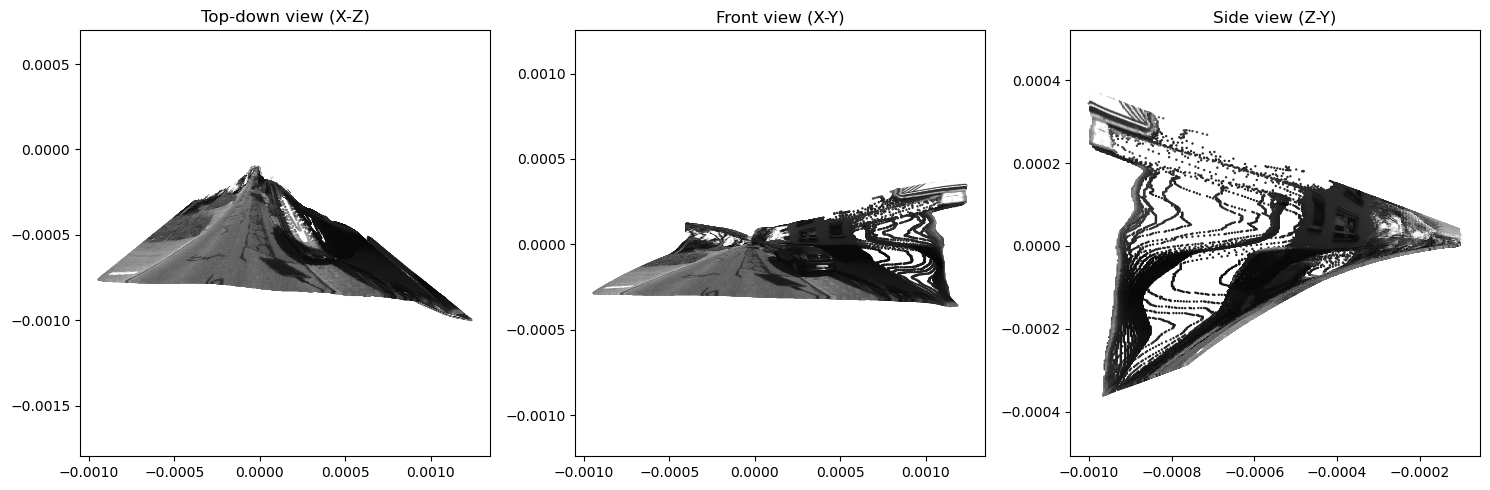

In [13]:
# Convert point cloud to numpy
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

# Plot 2D projections
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Top-down view (X, Z)
axs[0].scatter(points[:, 0], points[:, 2], c=colors, s=0.5)
axs[0].set_title("Top-down view (X-Z)")
axs[0].axis("equal")

# Front view (X, Y)
axs[1].scatter(points[:, 0], points[:, 1], c=colors, s=0.5)
axs[1].set_title("Front view (X-Y)")
axs[1].axis("equal")

# Side view (Z, Y)
axs[2].scatter(points[:, 2], points[:, 1], c=colors, s=0.5)
axs[2].set_title("Side view (Z-Y)")
axs[2].axis("equal")

plt.tight_layout()
plt.show()